In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

df = pd.read_csv('vw_amd.csv').drop(['Unnamed: 0'], axis=1)
df_calls = pd.read_csv('vw_calls.csv')
df = (df.merge(df_calls[['discussionid','starttimestamp','endtimestamp']], left_on='discussion_id', right_on='discussionid', how='left')
      .drop(['discussionid'], axis=1))

df['starttimestamp'] = pd.to_datetime(df['starttimestamp'])
df['endtimestamp'] = pd.to_datetime(df['endtimestamp'])
df['duration'] = (df['endtimestamp'] - df['starttimestamp']).dt.total_seconds()

In [3]:
df['date']= pd.to_datetime(df['date'])
df = df.sort_values(by='date').reset_index(drop=True)
df['picked']= ~df['amd']
df['caller']= df['caller'].astype(str)
df['period'] = df['date'].apply(lambda x: 'Before' if x < pd.Timestamp('2024-11-15') else 'After')
df.dropna()

,date,caller,callee,zip_code,zone,amd,discussion_id,starttimestamp,endtimestamp,duration,picked,period
0,2024-10-22,33162563937,33775809819,94310,1,False,CA74d24ab78a533777abc169f4c4c20b02,2024-10-22 16:20:50.479,2024-10-22 16:22:33.528,103.049,True,Before
1,2024-10-22,33162563937,33685248174,52310,3,True,CA30938917eb26da896e181273bdff8672,2024-10-22 17:45:46.313,2024-10-22 17:45:51.770,5.457,False,Before
2,2024-10-22,33162563937,33685248174,52310,3,True,CA8e55600eea89910cdb8bd5156fe95d57,2024-10-22 11:05:56.094,2024-10-22 11:06:00.216,4.122,False,Before
3,2024-10-22,33162563937,33614168055,76530,2,False,CA37f99a9cb92798846d2f6e50bcf34368,2024-10-23 08:03:47.845,2024-10-23 08:06:14.804,146.959,True,Before
4,2024-10-22,33162563937,33751497151,44230,2,True,CA0604c069767798c2c394f989b840c472,2024-10-22 15:51:04.506,2024-10-22 15:51:10.987,6.481,False,Before
...,...,...,...,...,...,...,...,...,...,...,...,...
2940,2024-12-03,33162563937,33753625404,93150,1,False,CA4cfe1c437402ed85b33dffcfe88f27e9,2024-12-03 18:37:49.358,2024-12-03 18:41:31.975,222.617,True,After
2941,2024-12-03,33270490602,33780243455,50300,2,False,CA993baddb98da86ce0df26cc8a5d9f667,2024-12-03 13:27:49.264,2024-12-03 13:28:06.632,17.368,True,After
2942,2024-12-03,33270490602,33780243455,50300,2,False,CAb2b3b1c15f8ebb20b9f91492db5db722,2024-12-03 17:20:54.459,2024-12-03 17:20:59.450,4.991,True,After
2943,2024-12-03,33162563937,33766006782,75000,1,False,CAbc54e9285d9c0e2fb39d5405e4de7557,2024-12-03 09:37:41.306,2024-12-03 09:37:46.275,4.969,True,After


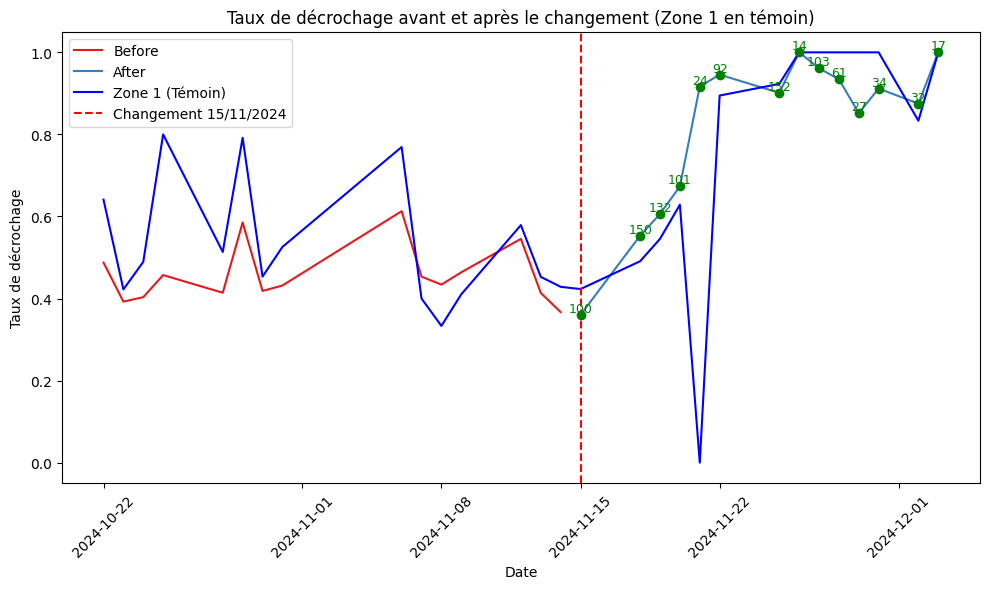

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer le taux de décrochage par jour pour toutes les périodes
daily_pickup_rate = df.groupby(['date', 'period'])['picked'].mean().reset_index()

# Filtrer les données pour la zone 1
zone1_data = df[df['zone'] == 1].groupby('date')['picked'].mean().reset_index()

# Calculer le nombre d'appels pour la période "After"
after_calls = df[df['period'] == 'After'].groupby('date').size().reset_index(name='call_count')

# Fusionner les données pour avoir le taux de décrochage et le nombre d'appels dans "After"
after_data = daily_pickup_rate[daily_pickup_rate['period'] == 'After'].merge(after_calls, on='date')


# Tracer le line plot
plt.figure(figsize=(10, 6))

# Tracé global (avant/après par période)
sns.lineplot(data=daily_pickup_rate, x='date', y='picked', hue='period', palette='Set1')

# Tracé pour la zone 1
sns.lineplot(data=zone1_data, x='date', y='picked', color='blue', linestyle='-', label='Zone 1 (Témoin)')

# Ligne verticale pour le changement
plt.axvline(pd.Timestamp('2024-11-15'), color='red', linestyle='--', label='Changement 15/11/2024')

for _, row in after_data.iterrows():
    plt.text(
        row['date'], 
        row['picked'],  # Position verticale sur la courbe
        f"{row['call_count']}", 
        fontsize=9, 
        color='green', 
        ha='center',
        va='bottom'  # Positionner légèrement au-dessus du point
    )
    plt.plot(
        row['date'], 
        row['picked'], 
        'o', 
        color='green'  # Ajout de points sur la courbe
    )


# Personnalisation du graphique
plt.title("Taux de décrochage avant et après le changement (Zone 1 en témoin)")
plt.ylabel("Taux de décrochage")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


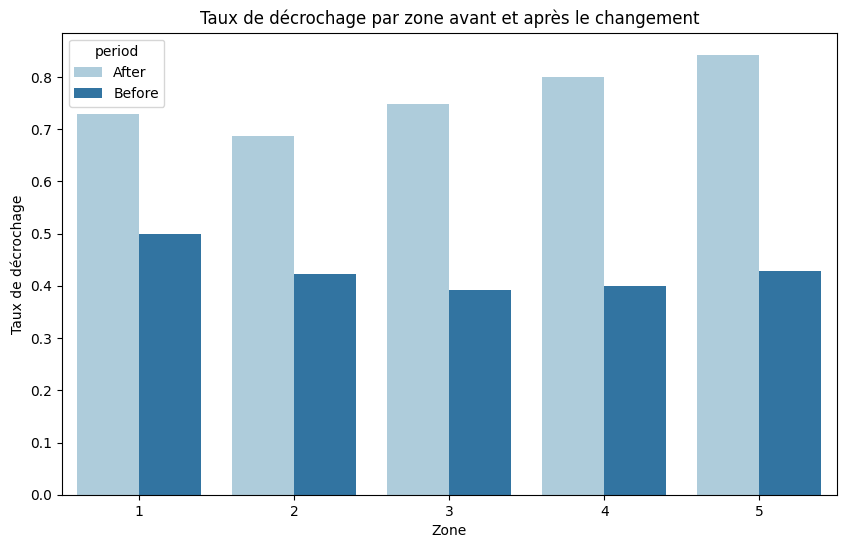

In [5]:
# Calculer le taux de décrochage par zone et période
pickup_rate_by_zone = df.groupby(['zone', 'period'])['picked'].mean().reset_index()

# Tracer un bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=pickup_rate_by_zone, x='zone', y='picked', hue='period', palette='Paired')
plt.title("Taux de décrochage par zone avant et après le changement")
plt.ylabel("Taux de décrochage")
plt.xlabel("Zone")
plt.show()

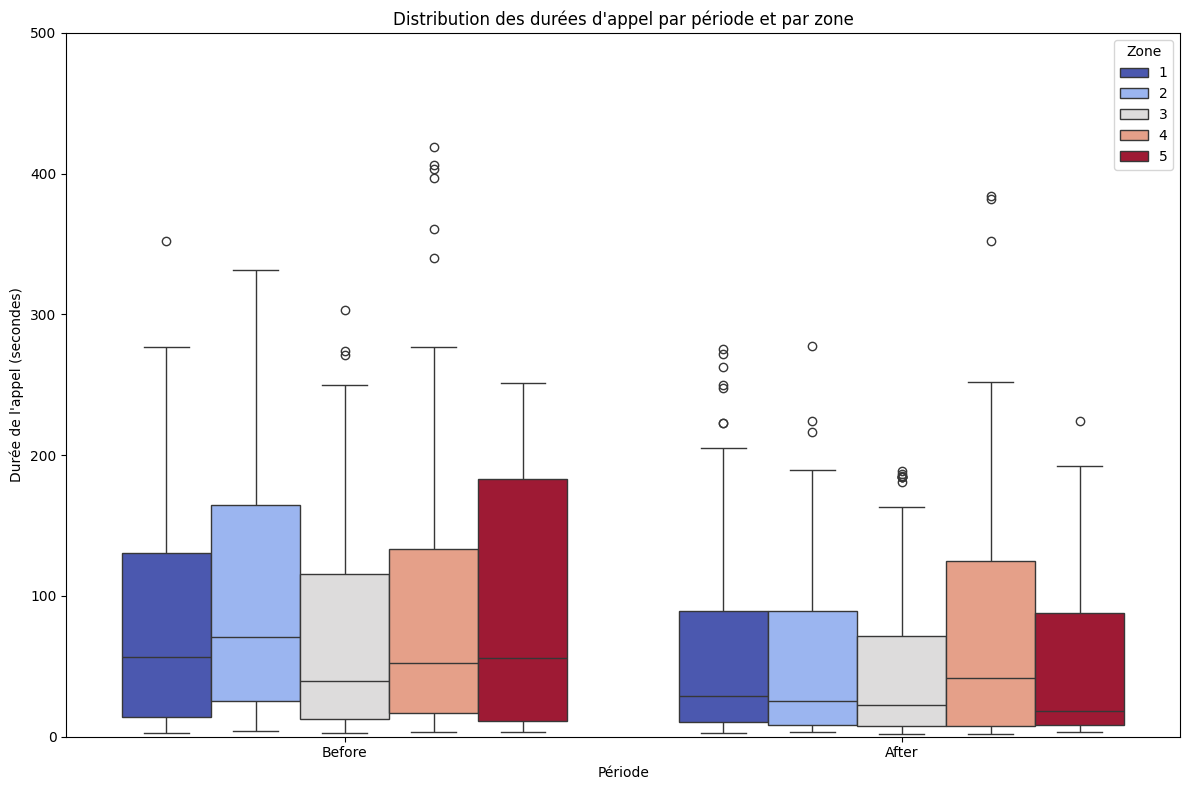

In [6]:
plt.figure(figsize=(12, 8))  # Augmenter la taille du graphique
sns.boxplot(data=df[df['amd']==False], x='period', y='duration', hue='zone', palette='coolwarm')
plt.title("Distribution des durées d'appel par période et par zone")
plt.ylabel("Durée de l'appel (secondes)")
plt.xlabel("Période")
plt.ylim(0, 500)  # Limiter l'axe des ordonnées à 500 secondes
plt.legend(title="Zone", loc='upper right')
plt.tight_layout()
plt.show()


In [7]:
# Filtrer les données où amd == False
filtered_df = df[df['amd'] == False]

# Fonction pour exclure les outliers
def count_without_outliers(group):
    q1 = group.quantile(0.25)  # Premier quartile
    q3 = group.quantile(0.75)  # Troisième quartile
    iqr = q3 - q1  # Intervalle interquartile
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Garder uniquement les points dans l'intervalle acceptable
    return group[(group >= lower_bound) & (group <= upper_bound)].count()

# Calcul des points sans outliers par zone et période
counts = filtered_df.groupby(['zone', 'period'])['duration'].apply(count_without_outliers).unstack()

# Afficher les résultats
for zone in counts.index:
    for period in counts.columns:
        count = counts.loc[zone, period]
        print(f"{period.capitalize()} zone {zone} : [{count} points]")

After zone 1 : [203 points]
Before zone 1 : [268 points]
After zone 2 : [145 points]
Before zone 2 : [116 points]
After zone 3 : [100 points]
Before zone 3 : [133 points]
After zone 4 : [206 points]
Before zone 4 : [180 points]
After zone 5 : [90 points]
Before zone 5 : [85 points]


/var/folders/x5/qmtm2vv54qzcmzx4h964n_nh0000gp/T/ipykernel_77593/2253698817.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pickup_rate_by_day = df.groupby(['day_of_week', 'period'])['picked'].mean().reset_index()


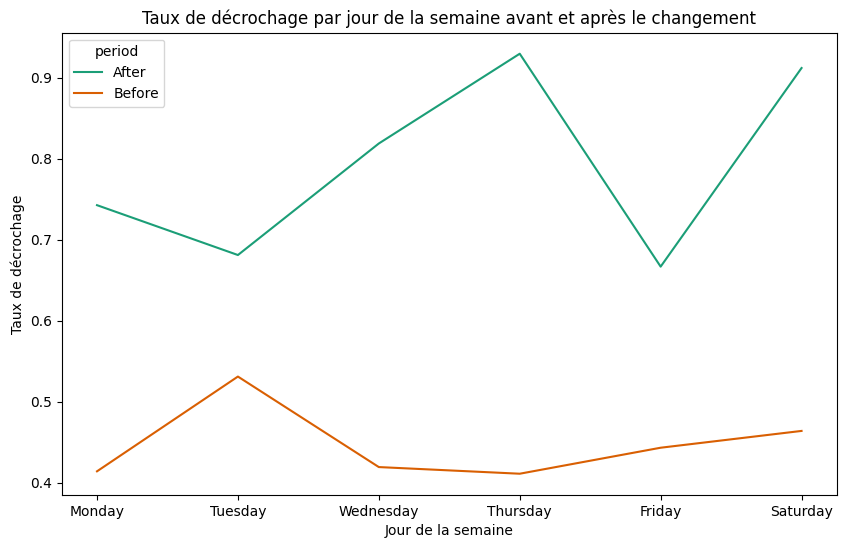

In [8]:
# Ajouter une colonne pour le jour de la semaine
df['day_of_week'] = df['date'].dt.day_name()

# Définir l'ordre des jours de la semaine
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)

# Calculer le taux de décrochage par jour de la semaine et par période
pickup_rate_by_day = df.groupby(['day_of_week', 'period'])['picked'].mean().reset_index()

# Tracer un line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=pickup_rate_by_day, x='day_of_week', y='picked', hue='period', palette='Dark2')
plt.title("Taux de décrochage par jour de la semaine avant et après le changement")
plt.ylabel("Taux de décrochage")
plt.xlabel("Jour de la semaine")
plt.show()